In [3]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt
from collections import OrderedDict 
import redis

import sys
import paths
sys.path.append(paths.scripts_root)
import util

%load_ext autoreload
%autoreload 2

# Display entire width of browser
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

print("Paths:")
for k,v in paths.path.items():
    print(" path.%s: %s" % (k,v))

# from Yesh's DIF_IP script
from pixval import Formatter
import blob_utils as bu
from enum import IntEnum
from skimage import measure

green = (0, 255, 0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Paths:
 path.projects_root: /Users/trafferty/data/projects
 path.images_root: /Users/trafferty/data/images
 path.results_root: /Users/trafferty/data/results
 path.ws_dir: /Users/trafferty/workspace
 path.scripts_root: /Users/trafferty/data/scripts
 path.tmp_dir: /Users/trafferty/tmp
 path.notebook_root: /Users/trafferty/data/notebooks
 path.tmp_root: /Users/trafferty/data/tmp


In [4]:
r = redis.StrictRedis(host='localhost', port=6379, db=0, decode_responses=True)

In [5]:
def zminmaxscore(r, key):
    try:
        min = r.zrangebyscore(key, '-inf', '+inf', withscores=True, start=1, num=1)[0][1]
        max = r.zrevrangebyscore(key, '+inf', '-inf', withscores=True, start=1, num=1)[0][1]
        return (min, max)
    except Exception as e:
        print( str(e) )
        return tuple()

# utils specific to DIF
#
def parseExpRoot(hash_in):
    # expRoot: "ExperimentID":run_num:"HeadSerialNumber":"NozzleSize":"MonomerID"
    return ':'.join(hash_in.split(':')[0:5])


In [7]:
completed_list = list(r.smembers('experiments_completed'))
exp_root = completed_list[0]
vel_hash = "%s:res_vel_set" % (exp_root)
volume_hash = "%s:res_vol_set" % (exp_root)

print (vel_hash)
print (volume_hash)

2017-10-02_08.42.46:1:SNX1227354:14:FF031A:res_vel_set
2017-10-02_08.42.46:1:SNX1227354:14:FF031A:res_vol_set


In [126]:
vol_min_max = zminmaxscore(r, volume_hash)
vel_min_max = zminmaxscore(r, vel_hash)

bin_cnt = 30
vol_bin_range = vol_min_max[1] - vol_min_max[0]
vol_bin_size = vol_bin_range /  bin_cnt
vel_bin_range = vel_min_max[1] - vel_min_max[0]
vel_bin_size  = vel_bin_range /  bin_cnt

print("Velocity min: %f, max: %f" % (vel_min_max[0], vel_min_max[1]))
print("Volume min  : %f, max: %f" % (vol_min_max[0], vol_min_max[1]))

Velocity min: 0.624399, max: 12.625871
Volume min  : 0.248978, max: 1.286535


In [127]:
vol_bin_sets = []
vol_bin_ranges = []
vol_hist_bins = []
print("Volume bins:")
for idx in range(bin_cnt):
    low = vol_min_max[0]+(idx*vol_bin_size)
    high = low + vol_bin_size
    zrange = r.zrangebyscore(volume_hash, low, high, withscores=True)
    vol_hist_bins.append( low+((high-low)/2.0)  )
    vol_bin_ranges.append( (low, high) )
    vol_bin_sets.append( zrange )
    print(" low = %f, high = %f, count=%d" % (low, high, len(zrange)) )
#vol_hist_bins.append(high)

vel_bin_sets = []
vel_bin_ranges = []
vel_hist_bins = []
print("Velocity bins:")
for idx in range(bin_cnt):
    low = vel_min_max[0]+(idx*vel_bin_size)
    high = low + vel_bin_size
    zrange = r.zrangebyscore(vel_hash, low, high, withscores=True)
    vel_hist_bins.append(low+((high-low)/2.0))
    vel_bin_ranges.append( (low, high) )
    vel_bin_sets.append( zrange )
    print(" low = %f, high = %f, count=%d" % (low, high, len(zrange)) )
#vel_hist_bins.append(high)

Volume bins:
 low = 0.248978, high = 0.283563, count=863
 low = 0.283563, high = 0.318148, count=1116
 low = 0.318148, high = 0.352734, count=1194
 low = 0.352734, high = 0.387319, count=1103
 low = 0.387319, high = 0.421904, count=1009
 low = 0.421904, high = 0.456489, count=906
 low = 0.456489, high = 0.491075, count=760
 low = 0.491075, high = 0.525660, count=703
 low = 0.525660, high = 0.560245, count=538
 low = 0.560245, high = 0.594830, count=437
 low = 0.594830, high = 0.629416, count=400
 low = 0.629416, high = 0.664001, count=334
 low = 0.664001, high = 0.698586, count=318
 low = 0.698586, high = 0.733171, count=257
 low = 0.733171, high = 0.767756, count=242
 low = 0.767757, high = 0.802342, count=180
 low = 0.802342, high = 0.836927, count=163
 low = 0.836927, high = 0.871512, count=147
 low = 0.871512, high = 0.906097, count=106
 low = 0.906097, high = 0.940683, count=99
 low = 0.940683, high = 0.975268, count=75
 low = 0.975268, high = 1.009853, count=56
 low = 1.009853, h

In [128]:
vel_bin_set = vel_bin_sets[0]
len(vel_bin_set)
vol_hist_bins

[0.2662706166666667,
 0.30085585000000004,
 0.33544108333333333,
 0.37002631666666674,
 0.40461155000000004,
 0.43919678333333334,
 0.47378201666666675,
 0.50836725,
 0.5429524833333332,
 0.5775377166666666,
 0.61212295,
 0.6467081833333332,
 0.6812934166666667,
 0.7158786500000001,
 0.7504638833333332,
 0.7850491166666667,
 0.8196343500000001,
 0.8542195833333333,
 0.8888048166666667,
 0.9233900500000001,
 0.9579752833333333,
 0.9925605166666667,
 1.02714575,
 1.0617309833333333,
 1.0963162166666667,
 1.13090145,
 1.1654866833333333,
 1.2000719166666667,
 1.23465715,
 1.2692423833333333]

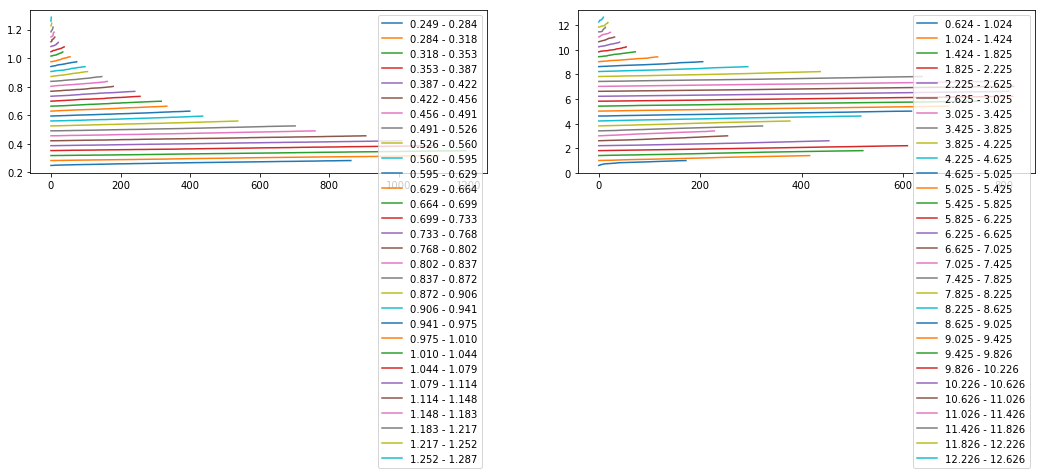

In [129]:
bin_scores_np = []
fig = plt.figure(figsize=(18,3))
ax1 = fig.add_subplot(121)
for idx, bin_set in enumerate(vol_bin_sets):
    bin_scores = []
    for b in bin_set:
        bin_scores.append(b[1])
    b_np = np.array(bin_scores)
    ax1.plot(b_np, label="%.3f - %.3f" % (vol_bin_ranges[idx][0], vol_bin_ranges[idx][1]))
    bin_scores_np.append(b_np)
ax1.legend(loc='best')

ax2 = fig.add_subplot(122)
for idx, bin_set in enumerate(vel_bin_sets):
    bin_scores = []
    for b in bin_set:
        bin_scores.append(b[1])
    b_np = np.array(bin_scores)
    ax2.plot(b_np, label="%.3f - %.3f" % (vel_bin_ranges[idx][0], vel_bin_ranges[idx][1]))
    bin_scores_np.append(b_np)
ax2.legend(loc='best')
plt.show()

0.266271 - 1.269242


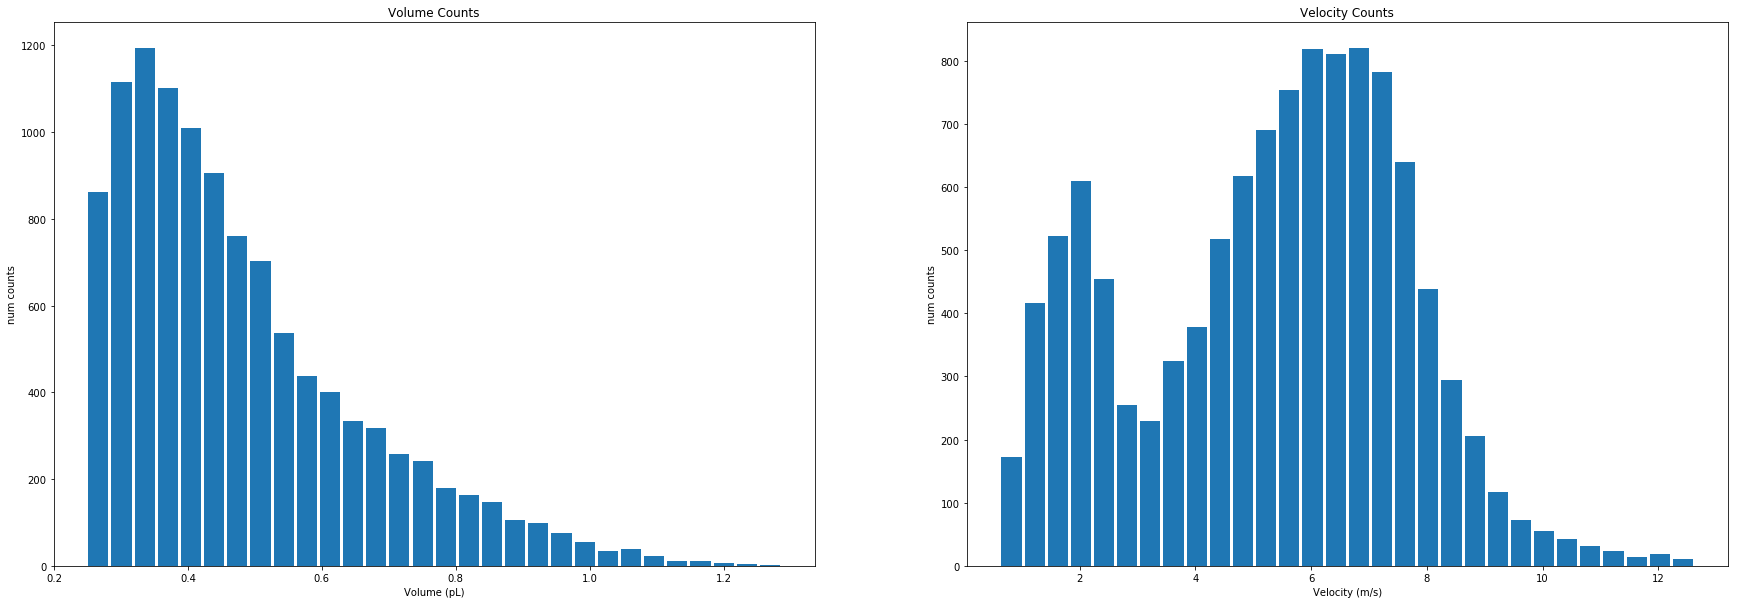

[863, 1116, 1194, 1103, 1009, 906, 760, 703, 538, 437, 400, 334, 318, 257, 242, 180, 163, 147, 106, 99, 75, 56, 35, 39, 22, 12, 10, 7, 3, 2]
[173, 417, 522, 610, 455, 255, 229, 324, 378, 518, 618, 690, 753, 818, 810, 820, 782, 639, 438, 295, 206, 117, 73, 55, 42, 32, 24, 14, 19, 10]


In [130]:
vol_bin_score_counts = []
for idx, bin_set in enumerate(vol_bin_sets):
    vol_bin_score_counts.append(len(bin_set))
vol_bin_score_counts

vel_bin_score_counts = []
for idx, bin_set in enumerate(vel_bin_sets):
    vel_bin_score_counts.append(len(bin_set))
vel_bin_score_counts

plt.clf()
fig = plt.figure(figsize=(30,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

print("%f - %f" % (vol_hist_bins[0], vol_hist_bins[-1]))

ax1.bar(vol_hist_bins, vol_bin_score_counts, ((vol_hist_bins[-1] - vol_hist_bins[-0])/bin_cnt)*.9 )
ax1.set(title="Volume Counts", ylabel="num counts", xlabel="Volume (pL)")
#ax1.xaxis.set(ticks=vol_hist_bins)

ax2.bar(vel_hist_bins, vel_bin_score_counts, ((vel_hist_bins[-1] - vel_hist_bins[-0])/bin_cnt)*.9)
ax2.set(title="Velocity Counts", ylabel="num counts", xlabel="Velocity (m/s)")
#ax2.xaxis.set(ticks=vel_hist_bins)
plt.show()

print(vol_bin_score_counts)
print(vel_bin_score_counts)

In [ ]:
select 